# Simulation experiment for detection thresholds for variant calling

This notebook is to get detection thresholds for the limit of the variant calling based on: 

1. Read depth
2. Error rate
3. Number of mutations


Also optionaly get the time it takes to complete experiments per sequence length.


```
>lcl|NC_000913.3_cds_NP_414902.1_362 [gene=tauD] [locus_tag=b0368] [db_xref=UniProtKB/Swiss-Prot:P37610] [protein=taurine dioxygenase] [protein_id=NP_414902.1] [location=387795..388646] [gbkey=CDS]
```

From: ecoli_GCF_000005845.2_ASM584v2_cds_from_genomic.fna
and >NP_414902.1 taurine dioxygenase [Escherichia coli str. K-12 substr. MG1655]



In [3]:
import pandas as pd


# Introduce mutations at a given frequency and an error rate

Test setup:

1. For number of mutations from 1 to the sequence length test mutating each one and correlate this to the p value
2. For sequencing error rates from 0 to 100% make sequences ranging with this and see what the results are for the p value and the error
3. For different sequence lengths also check how sequence length corresponds to the pvalue

In [17]:
def get_dummy_plate_df(number_of_wells=96):
    """
    Make a dummy plate.
    Plate	Well	Path	Alignment_count	P value	Mixed Well	Variant	Average mutation frequency	P adj. value
    """
    df = pd.DataFrame([i for i in range(0, number_of_wells)], columns=['index'])
    df['Plate'] = 'Plate'
    df['Well'] = 'Well'
    df['Path'] = ''
    df['Alignment_count'] = 0
    df['P value'] = 1.0
    df['Mixed Well'] = False
    df['Variant'] = ''
    df['mutation'] = ''
    df['frequency'] = 0.0
    df['P adj.'] = 0.0
    df['value'] = 0
    df.set_index('index', inplace=True)
    return df

,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,value
index,,,,,,,,,,,
0,Plate,Well,,0,1.0,False,,,0,0,0
1,Plate,Well,,0,1.0,False,,,0,0,0
2,Plate,Well,,0,1.0,False,,,0,0,0
3,Plate,Well,,0,1.0,False,,,0,0,0
4,Plate,Well,,0,1.0,False,,,0,0,0
5,Plate,Well,,0,1.0,False,,,0,0,0
6,Plate,Well,,0,1.0,False,,,0,0,0
7,Plate,Well,,0,1.0,False,,,0,0,0
8,Plate,Well,,0,1.0,False,,,0,0,0


In [24]:
from sciutil import *

u = SciUtil()

# Generate mutations on a "real" sequence
# Decided to choose tauD from Ecoli K12
parent_sequence_aa = 'MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVFLRDQAITPQQQRALAQRFGELHIHPVYPHAEGVD\
EIIVLDTHNDNPPDNDNWHTDVTFIETPPAGAILAAKELPSTGGDTLWTSGIAAYEALSVPFRQLLSGLRAEHDFRKSFP\
EYKYRKTEEEHQRWREAVAKNPPLLHPVVRTHPVSGKQALFVNEGFTTRIVDVSEKESEALLSFLFAHITKPEFQVRWRW\
QPNDIAIWDNRVTQHYANADYLPQRRIMHRATILGDKPFYRAG'

parent_sequence = 'ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTT\
AAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGC\
CGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGAC\
GAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAAC\
GCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGG\
CCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCG\
GAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCC\
GGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGA\
GCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGG\
CAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGAT\
AATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA'

sequencing_error_rate = 0.1
read_depth = 100
positions = [0]

mutated_sequence = make_ssm_de_experiment(read_depth, sequencing_error_rate, parent_sequence, positions,
                                          parent_sequence_aa, amino_acid_to_codon)

variant_df = get_dummy_plate_df(19)  # i.e. 20 - 1 since we don't have the other variant

mutant_to_well_df = {}
number_of_wells = 20  # just 
current_well = 0
for mutant in mutated_sequence:
    parent_name = 'Parent'
    reads = []
    read_ids = []
    quals = []
    for i, seq in enumerate(mutated_sequence[mutant]):
        read_ids.append(f'read_{i}')
        reads.append(seq)
        quals.append(100)  # Dummy don't need

    well_df = make_well_df_from_reads(reads, read_ids, quals)
    rows_all = make_row_from_read_pileup_across_well(well_df, parent_sequence, parent_name)
    well_df = pd.DataFrame(rows_all)
    well_df.columns = ['gene_name', 'position', 'ref', 'most_frequent', 'freq_non_ref', 'total_other',
                       'total_reads', 'p_value', 'percent_most_freq_mutation', 'A', 'p(a)', 'T', 'p(t)', 'G',
                       'p(g)',
                       'C', 'p(c)', 'N', 'p(n)']
    well_df = calculate_mutation_significance_across_well(well_df)
    label, frequency, combined_p_value, mixed_well = get_variant_label_for_well(well_df, 0.5)
    # This should be mutated at 100% - the rate of our sequencing errror
    u.dp([f"Input parent: {parent_sequence}", f"Variant: {mutant}"])
    u.dp(["label", label, f"frequency", frequency, f"combined_p_value", combined_p_value, "mixed_well", mixed_well])
    mutant_to_well_df[f'{mutant}_{number_checked}'] = well_df
    variant_df.at[current_well, "Mixed Well"] = mixed_well
    variant_df.at[current_well, "Variant"] = label
    variant_df.at[current_well, "frequency"] = frequency
    variant_df.at[current_well, "P value"] = combined_p_value

    if current_well == number_of_wells:
        break
    current_well += 1

--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: GCTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

In [46]:
def get_dummy_plate_df(plate_name='Plate', well_name='Well', number_of_wells=96):
    """
    Make a dummy plate.
    Plate	Well	Path	Alignment_count	P value	Mixed Well	Variant	Average mutation frequency	P adj. value
    """
    df = pd.DataFrame([i for i in range(0, number_of_wells)], columns=['index'])
    df['Plate'] = plate_name
    df['Well'] = well_name
    df['Path'] = ''
    df['Alignment_count'] = 0
    df['P value'] = 1.0
    df['Mixed Well'] = False
    df['Variant'] = ''
    df['mutation'] = ''
    df['frequency'] = 0
    df['P adj.'] = 1.0
    df.set_index('index', inplace=True)
    return df

def make_experiment(run_label, read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells):
    # Make a full experiment setup
    mutated_sequence = make_ssm_de_experiment(read_depth, sequencing_error_rate, parent_sequence, positions,
                                              parent_sequence_aa, amino_acid_to_codon)
    
    variant_df = get_dummy_plate_df(run_label, 'Well', number_of_wells - 1)  # i.e. 20 - 1 since we don't have the other variant    
    mutant_to_well_df = {}
    current_well = 0
    for mutant in mutated_sequence:
        parent_name = 'Parent'
        reads = []
        read_ids = []
        quals = []
        for i, seq in enumerate(mutated_sequence[mutant]):
            read_ids.append(f'read_{i}')
            reads.append(seq)
            quals.append(100)  # Dummy don't need
    
        well_df = make_well_df_from_reads(reads, read_ids, quals)
        rows_all = make_row_from_read_pileup_across_well(well_df, parent_sequence, parent_name)
        well_df = pd.DataFrame(rows_all)
        well_df.columns = ['gene_name', 'position', 'ref', 'most_frequent', 'freq_non_ref', 'total_other',
                           'total_reads', 'p_value', 'percent_most_freq_mutation', 'A', 'p(a)', 'T', 'p(t)', 'G',
                           'p(g)',
                           'C', 'p(c)', 'N', 'p(n)']
        well_df = calculate_mutation_significance_across_well(well_df)
        label, frequency, combined_p_value, mixed_well = get_variant_label_for_well(well_df, 0.5)
        # This should be mutated at 100% - the rate of our sequencing errror
        u.dp([f"Input parent: {parent_sequence}", f"Variant: {mutant}"])
        u.dp(["label", label, f"frequency", frequency, f"combined_p_value", combined_p_value, "mixed_well", mixed_well])
        mutant_to_well_df[f'{mutant}_{number_checked}'] = well_df
        variant_df.at[current_well, "Mixed Well"] = mixed_well
        variant_df.at[current_well, "Variant"] = label
        variant_df.at[current_well, "frequency"] = frequency
        variant_df.at[current_well, "P value"] = combined_p_value
        variant_df.at[current_well, "Well"] = f'Well {current_well}'
        variant_df.at[current_well, "Alignment_count"] = read_depth
        current_well += 1

    # Before returning adjust the pvalues
    variant_df['P adj.'] = multipletests(list(variant_df["P value"].values), alpha=0.05, method='fdr_bh')[1]
    return variant_df

In [47]:
# We're going to make an experiment of 10 plates with different sequencing error rates
read_depth = 100
positions = [0]
number_of_wells = 20
experiment_df = pd.DataFrame()
for sequencing_error in range(0, 100, 10):
    sequencing_error_rate = sequencing_error/100.0
    print(sequencing_error)
    run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells)
    run_df.reset_index(inplace=True)
    experiment_df = pd.concat([experiment_df, run_df])



0
--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: GCTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATAT

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9033333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8133333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7566666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.23888888888888887' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1767910447761194' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19292270531400968' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.218368544600939' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.247406103286385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/3347024795.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27532863849765266' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency


--------------------------------------------------------------------------------
Input parent: ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTTAAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGCCGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGACGAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAACGCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGGCCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCGGAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCCGGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGAGCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGGCAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGATAATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA	Variant: TGTAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCG

In [48]:
experiment_df

,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.
0,0,SeqError_0,Well 0,,100,0.0,False,A1G_T2C_G3T,,1.000000,0.0
1,1,SeqError_0,Well 1,,100,0.0,False,A1T_T2G_G3T,,1.000000,0.0
2,2,SeqError_0,Well 2,,100,0.0,False,A1G_T2A_G3T,,1.000000,0.0
3,3,SeqError_0,Well 3,,100,0.0,False,A1G_T2A_G3A,,1.000000,0.0
4,4,SeqError_0,Well 4,,100,0.0,False,A1T_G3T,,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14,14,SeqError_90,Well 14,,100,1.0,False,A1DEL_T2A_G3DEL_A4T_G5C_T6DEL_G7T_A8DEL_A9G_C1...,,0.274507,1.0
15,15,SeqError_90,Well 15,,100,1.0,False,A1DEL_T2DEL_G3A_A4DEL_G5DEL_T6DEL_G7A_A8G_A9G_...,,0.274871,1.0
16,16,SeqError_90,Well 16,,100,1.0,False,A1T_T2C_G3DEL_A4G_G5DEL_T6C_G7A_A8G_A9T_C10A_G...,,0.274143,1.0
17,17,SeqError_90,Well 17,,100,1.0,False,A1G_T2DEL_G3T_A4T_G5DEL_T6C_G7DEL_A8T_A9DEL_C1...,,0.274800,1.0


In [97]:
# Visualisation things to make the figures look nice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sciutil import SciUtil


plt.rcParams['svg.fonttype'] = 'none'
axis_line_width = 1.0
axis_font_size = 12
title_font_size = 12
label_font_size = 10
figsize = (5, 4) # Figure size
font = 'Arial'
style = 'ticks'
font_family = 'sans-serif'

# Create a figure with 2x2 subplots
sns.set_style("whitegrid")
cmap = 'viridis'
palette = sns.color_palette("viridis", as_cmap=True)
sns.set_palette(cmap)

sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, style=style)

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=axis_line_width)
    ax.spines['bottom'].set_linewidth(axis_line_width)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(axis_line_width)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=axis_font_size)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.tick_params(labelsize=label_font_size)



/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/2750583280.py:2: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_58547/2717425446.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


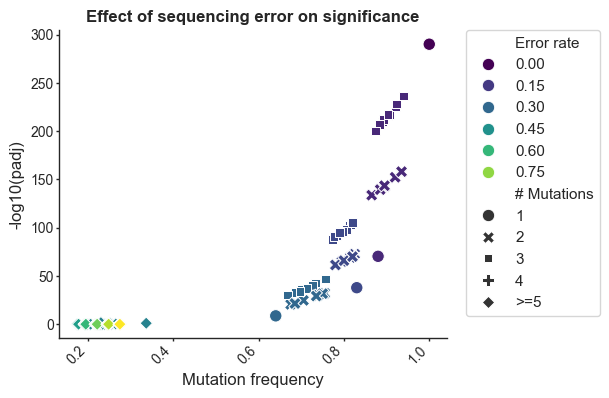

In [105]:
import seaborn as sns
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]

experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
#experiment_df = experiment_df.reset_index()
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
                     style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of sequencing error on significance', fontsize=title_font_size, fontweight=800)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [72]:
experiment_df

,level_0,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,-log10(P.adj)
0,0,0,SeqError_0,Well 0,,100,0.0,False,A1G_T2C_G3T,,1.000000,0.0,inf
1,1,1,SeqError_0,Well 1,,100,0.0,False,A1T_T2G_G3T,,1.000000,0.0,inf
2,2,2,SeqError_0,Well 2,,100,0.0,False,A1G_T2A_G3T,,1.000000,0.0,inf
3,3,3,SeqError_0,Well 3,,100,0.0,False,A1G_T2A_G3A,,1.000000,0.0,inf
4,4,4,SeqError_0,Well 4,,100,0.0,False,A1T_G3T,,1.000000,0.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,14,14,SeqError_90,Well 14,,100,1.0,False,A1DEL_T2A_G3DEL_A4T_G5C_T6DEL_G7T_A8DEL_A9G_C1...,,0.274507,1.0,-0.0
186,15,15,SeqError_90,Well 15,,100,1.0,False,A1DEL_T2DEL_G3A_A4DEL_G5DEL_T6DEL_G7A_A8G_A9G_...,,0.274871,1.0,-0.0
187,16,16,SeqError_90,Well 16,,100,1.0,False,A1T_T2C_G3DEL_A4G_G5DEL_T6C_G7A_A8G_A9T_C10A_G...,,0.274143,1.0,-0.0
188,17,17,SeqError_90,Well 17,,100,1.0,False,A1G_T2DEL_G3T_A4T_G5DEL_T6C_G7DEL_A8T_A9DEL_C1...,,0.274800,1.0,-0.0


In [40]:
# We're going to make an experiment of 10 plates with different sequencing error rates
read_depth = 100
positions = [0, 1, 2]
number_of_wells = 20
experiment_df = pd.DataFrame()
for sequencing_error in range(0, 100, 10):
    sequencing_error_rate = sequencing_error/100.0
    print(sequencing_error)
    run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, parent_sequence_aa, amino_acid_to_codon, number_of_wells)
    run_df.reset_index(inplace=True)
    experiment_df = pd.concat([experiment_df, run_df])


,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,value
0,0,SeqError_0,Well 0,,0,0.000000e+00,False,A1G_T2C_G3T,,1.000000,0,0
1,1,SeqError_0,Well 1,,0,0.000000e+00,False,A1T_T2G_G3T,,1.000000,0,0
2,2,SeqError_0,Well 2,,0,0.000000e+00,False,A1G_T2A_G3T,,1.000000,0,0
3,3,SeqError_0,Well 3,,0,0.000000e+00,False,A1G_T2A_G3A,,1.000000,0,0
4,4,SeqError_0,Well 4,,0,0.000000e+00,False,A1T_G3T,,1.000000,0,0
5,5,SeqError_0,Well 5,,0,0.000000e+00,False,A1G_T2G_G3T,,1.000000,0,0
6,6,SeqError_0,Well 6,,0,0.000000e+00,False,A1C_T2A_G3T,,1.000000,0,0
7,7,SeqError_0,Well 7,,0,7.699812e-291,False,G3T,,1.000000,0,0
8,8,SeqError_0,Well 8,,0,0.000000e+00,False,T2A_G3A,,1.000000,0,0
9,9,SeqError_0,Well 9,,0,0.000000e+00,False,A1C_G3T,,1.000000,0,0


# Make some experiments and see what the rates are that we call errors

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
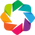

In [5]:
import sys
from minION import IO_processor
from minION import Basecaller

from minION.variantcaller import *



In [6]:
# Now using our reads we can make a sequence DF
from minION.utils import *

parent_name = 'parent'
reads = []
read_ids = []
quals = []
for mutated in mutated_sequence:
    for i, seq in enumerate(mutated_sequence[mutated]):
        read_ids.append(f'read_{i}')
        reads.append(seq)
        quals.append(100)  # Dummy don't need 
    break
well_df = make_well_df_from_reads(reads, read_ids, quals)
rows_all = make_row_from_read_pileup_across_well(well_df, parent_sequence, parent_name)
well_df = pd.DataFrame(rows_all)
well_df.columns = ['gene_name', 'position', 'ref', 'most_frequent', 'freq_non_ref', 'total_other',
                  'total_reads', 'p_value', 'percent_most_freq_mutation', 'A', 'p(a)', 'T', 'p(t)', 'G', 'p(g)',
                  'C', 'p(c)', 'N', 'p(n)']
well_df = calculate_mutation_significance_across_well(well_df)
label, probability, combined_p_value, mixed_well =  get_variant_label_for_well(well_df, 0.5)

NameError: name 'mutated_sequence' is not defined

In [ ]:
well_df

In [ ]:
label, probability, combined_p_value, mixed_well 

In [ ]:
make_well_df_from_reads(reads, read_ids, quals)